In [ ]:
from utils import LMDBDataset

dataset = LMDBDataset('data/graphs/QM40', split='train')
print(len(dataset))

123643


In [29]:
graph = dataset[0]
node_labels = graph['node_labels']
print(node_labels.shape)
adjacency_matrix = graph['adjacency_matrix']
print(adjacency_matrix.shape)
edges_labels = graph['edges_labels']
print(edges_labels.shape)
SP_matrix = graph['SP_matrix']
print(SP_matrix.shape)
print(SP_matrix[:10,:10])

torch.Size([24, 33])
torch.Size([24, 24])
torch.Size([24, 24, 5])
torch.Size([24, 24])
tensor([[0, 1, 2, 3, 4, 5, 5, 6, 7, 8],
        [1, 0, 1, 2, 3, 4, 4, 5, 6, 7],
        [2, 1, 0, 1, 2, 3, 3, 4, 5, 6],
        [3, 2, 1, 0, 1, 2, 2, 3, 4, 5],
        [4, 3, 2, 1, 0, 1, 2, 3, 4, 5],
        [5, 4, 3, 2, 1, 0, 1, 2, 3, 4],
        [5, 4, 3, 2, 2, 1, 0, 1, 2, 3],
        [6, 5, 4, 3, 3, 2, 1, 0, 1, 2],
        [7, 6, 5, 4, 4, 3, 2, 1, 0, 1],
        [8, 7, 6, 5, 5, 4, 3, 2, 1, 0]], dtype=torch.uint8)


In [30]:
n = min(100000, len(dataset))

def iterate_dataset(dataset):  
    for i in range(n):
        data = dataset[i]
        if isinstance(data, tuple):
            graph, target = data
        else:
            graph = data
        yield graph

In [32]:
all_dists = []
for graph in iterate_dataset(dataset):
    all_dists.append( torch.max(graph['SP_matrix']))
all_dists = torch.tensor(all_dists)

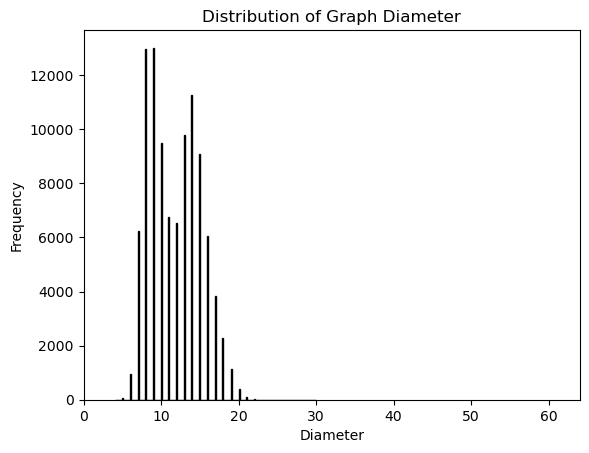

In [33]:
import matplotlib.pyplot as plt

plt.hist(all_dists, bins=200, edgecolor='black')
plt.xlim(0, 64)
plt.title('Distribution of Graph Diameter')
plt.xlabel('Diameter')
plt.ylabel('Frequency')
plt.show()